<a href="https://colab.research.google.com/github/jkDina/Ladnyuk/blob/master/les4/cifar10_tricks_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 с трюками

В этом задании мы продолжим работать с CIFAR-10, опробовав трюки, про которые мы узнали в 4 модуле.

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов: 

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [2]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
from keras import backend as K

1.14.0-rc1
2.2.4


In [0]:
# чистит сессию в Keras и TF
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

# Загружаем данные

In [4]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 13s 0us/step


In [5]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [0]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


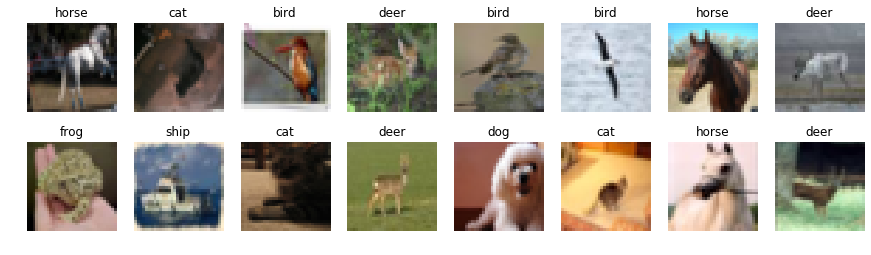

In [7]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [0]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [0]:
# слои, которые нам пригодятся
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе; 
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='elu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [0]:
def make_default_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=3, strides=1, padding='same', activation='elu', input_shape=(32, 32, 3)))  # input_shape задаем только на первом слое
    model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='elu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='elu'))
    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='elu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [11]:
s = reset_tf_session()
model = make_default_model()
model.summary()

W0618 12:20:42.373098 139794074519424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0618 12:20:42.375315 139794074519424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0618 12:20:42.416728 139794074519424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 12:20:43.659655 139794074519424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W061

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

# Тренируем модель

In [0]:
def train_model(make_model_func=make_default_model, optimizer="adam"):
  BATCH_SIZE = 32
  EPOCHS = 10

  s = reset_tf_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )
  
  return model

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:



1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?
2.   Измените в дефолтной архитектуре **elu активацию на sigmoid**, какое качество на валидации получили?
3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?
5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **elu активацию на sigmoid**,  какое качество на валидации получили?
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


In [14]:
# учим дефолтную архитектуру
train_model()

W0618 12:22:36.558936 139794074519424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0618 12:22:36.693681 139794074519424 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 17s 343us/step - loss: 1.3179 - acc: 0.5369 - val_loss: 1.0855 - val_acc: 0.6194
Epoch 2/10
50000/50000 [==============================] - 12s 231us/step - loss: 1.0832 - acc: 0.6223 - val_loss: 1.0198 - val_acc: 0.6423
Epoch 3/10
50000/50000 [==============================] - 12s 232us/step - loss: 0.9907 - acc: 0.6549 - val_loss: 0.9498 - val_acc: 0.6675
Epoch 4/10
50000/50000 [==============================] - 11s 230us/step - loss: 0.9310 - acc: 0.6757 - val_loss: 0.9263 - val_acc: 0.6846
Epoch 5/10
50000/50000 [==============================] - 11s 230us/step - loss: 0.8701 - acc: 0.6935 - val_loss: 0.8415 - val_acc: 0.7171
Epoch 6/10
50000/50000 [==============================] - 11s 229us/step - loss: 0.8242 - acc: 0.7088 - val_loss: 0.8318 - val_acc: 0.7148
Epoch 7/10
50000/50000 [==============================] - 11s 229us/step - loss: 0.7832 - acc: 0.7263 - val_loss: 0.

In [0]:
def make_sigmoid_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=3, strides=1, padding='same', activation='sigmoid', input_shape=(32, 32, 3)))  # input_shape задаем только на первом слое
    model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='sigmoid'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='sigmoid'))
    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='sigmoid'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='sigmoid'))
    
    return model

In [22]:
# учим sigmoid
train_model(make_sigmoid_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 236us/step - loss: 2.3046 - acc: 0.0988 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/10
50000/50000 [==============================] - 11s 229us/step - loss: 2.3027 - acc: 0.1005 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/10
50000/50000 [==============================] - 11s 228us/step - loss: 2.3026 - acc: 0.1013 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/10
50000/50000 [==============================] - 12s 231us/step - loss: 2.3026 - acc: 0.0997 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 5/10
50000/50000 [==============================] - 11s 228us/step - loss: 2.3026 - acc: 0.0999 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 6/10
50000/50000 [==============================] - 12s 231us/step - loss: 2.3027 - acc: 0.0987 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/10
50000/50000 [==============================] - 11s 229us/step - loss: 2.3026 - acc: 0.0978 - val_loss: 2.

In [23]:

# учим sgd
train_model(optimizer="sgd")

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 209us/step - loss: 1.7524 - acc: 0.3689 - val_loss: 1.5366 - val_acc: 0.4499
Epoch 2/10
50000/50000 [==============================] - 10s 198us/step - loss: 1.4811 - acc: 0.4708 - val_loss: 1.3351 - val_acc: 0.5250
Epoch 3/10
50000/50000 [==============================] - 10s 199us/step - loss: 1.3105 - acc: 0.5371 - val_loss: 1.2066 - val_acc: 0.5690
Epoch 4/10
50000/50000 [==============================] - 10s 199us/step - loss: 1.1717 - acc: 0.5899 - val_loss: 1.1081 - val_acc: 0.6110
Epoch 5/10
50000/50000 [==============================] - 10s 198us/step - loss: 1.0918 - acc: 0.6169 - val_loss: 1.0047 - val_acc: 0.6490
Epoch 6/10
50000/50000 [==============================] - 10s 197us/step - loss: 1.0370 - acc: 0.6365 - val_loss: 0.9940 - val_acc: 0.6457
Epoch 7/10
50000/50000 [==============================] - 10s 200us/step - loss: 0.9974 - acc: 0.6516 - val_loss: 0.

In [0]:
def make_bn_model():
  model = Sequential()
  model.add(Conv2D(16, kernel_size=3, strides=1, padding='same', activation='elu', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='elu'))
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D())
  model.add(Dropout(0.25))
  
  model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='elu'))
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D())
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='elu'))
  model.add(BatchNormalization())
  
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))
  
  return model
  


In [27]:
# учим bn
train_model(make_bn_model)

W0618 12:54:59.899474 139794074519424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 19s 387us/step - loss: 1.4707 - acc: 0.5017 - val_loss: 1.0786 - val_acc: 0.6286
Epoch 2/10
50000/50000 [==============================] - 19s 373us/step - loss: 1.0362 - acc: 0.6362 - val_loss: 0.8874 - val_acc: 0.7002
Epoch 3/10
50000/50000 [==============================] - 19s 375us/step - loss: 0.8996 - acc: 0.6862 - val_loss: 0.8077 - val_acc: 0.7258
Epoch 4/10
50000/50000 [==============================] - 19s 374us/step - loss: 0.8086 - acc: 0.7182 - val_loss: 0.7302 - val_acc: 0.7444
Epoch 5/10
50000/50000 [==============================] - 19s 374us/step - loss: 0.7426 - acc: 0.7421 - val_loss: 0.6866 - val_acc: 0.7608
Epoch 6/10
50000/50000 [==============================] - 19s 378us/step - loss: 0.6755 - acc: 0.7649 - val_loss: 0.6561 - val_acc: 0.7741
Epoch 7/10
50000/50000 [==============================] - 19s 374us/step - loss: 0.6305 - acc: 0.7788 - val_loss: 0.

In [0]:
def make_sigmoid_bn_model():
  model = Sequential()
  model.add(Conv2D(16, kernel_size=3, strides=1, padding='same', activation='sigmoid', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='sigmoid'))
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D())
  model.add(Dropout(0.25))
  
  model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='sigmoid'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='sigmoid'))
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D())
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='sigmoid'))
  model.add(BatchNormalization())
  
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))
  
  return model

In [31]:
# учим sigmoid + bn
train_model(make_sigmoid_bn_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 19s 388us/step - loss: 1.6308 - acc: 0.4214 - val_loss: 1.4120 - val_acc: 0.5097
Epoch 2/10
50000/50000 [==============================] - 19s 381us/step - loss: 1.2331 - acc: 0.5624 - val_loss: 1.0256 - val_acc: 0.6305
Epoch 3/10
50000/50000 [==============================] - 19s 375us/step - loss: 1.0787 - acc: 0.6194 - val_loss: 0.9953 - val_acc: 0.6528
Epoch 4/10
50000/50000 [==============================] - 19s 375us/step - loss: 0.9939 - acc: 0.6521 - val_loss: 0.8841 - val_acc: 0.6945
Epoch 5/10
50000/50000 [==============================] - 19s 375us/step - loss: 0.9323 - acc: 0.6734 - val_loss: 0.8861 - val_acc: 0.6964
Epoch 6/10
50000/50000 [==============================] - 19s 375us/step - loss: 0.8913 - acc: 0.6896 - val_loss: 0.8404 - val_acc: 0.7068
Epoch 7/10
50000/50000 [==============================] - 19s 375us/step - loss: 0.8500 - acc: 0.7026 - val_loss: 0.